In [2]:
import sys
sys.path.append("../")

from src.dataloader.meta_loader_mfcc import Dataloader4SER, NShotMAMLSampler, SERNShot
from src.audio.audio import AudioProcessor

from src.meta_learner.meta_learner import Meta

import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\lucas\Anaconda3\envs\m_audio\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\lucas\Anaconda3\envs\m_audio\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
C:\Users\lucas\Anaconda3\envs\m_audio\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [16]:
# Testing loader
N_WAY = 3
K_SHOT = 1
K_QUERY = 1
import torch.utils.data as data
import torch

ap = AudioProcessor(fft_size = 1024,
                    hop_length = 256,
                    win_length = 1024,
                    pad_wav=False,
                    num_mels = 80,
                    mel_fmin = 80,
                    mel_fmax = 7600,
                    sample_rate = 22050,
                    duration = None,
                    resample = True,
                    signal_norm= True,
                    ref_level_db = 20,
                    min_level_db = -100,
                    symetric_norm = True,
                    max_norm = 4)

nshot = SERNShot(df_train_path = 'df.csv', df_test_path = 'df.csv', ap = ap, batch_size = 10, n_way = N_WAY, k_shot = K_SHOT, k_query = K_QUERY, pad_to = 100, pad_value = -3)

 > Setting up Audio Processor...
 | > sample_rate:22050
 | > resample:True
 | > duration:None
 | > num_mels:80
 | > log_func:np.log10
 | > min_level_db:-100
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:20
 | > fft_size:1024
 | > power:None
 | > preemphasis:0.0
 | > griffin_lim_iters:None
 | > signal_norm:True
 | > symmetric_norm:None
 | > mel_fmin:80
 | > mel_fmax:7600
 | > spec_gain:20.0
 | > stft_pad_mode:reflect
 | > max_norm:4.0
 | > clip_norm:True
 | > do_trim_silence:False
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > stats_path:None
 | > base:10
 | > hop_length:256
 | > win_length:1024
There are 3 samples for training and 3 for out-of-distribution language.
n_class train = 3 | n_class test = 3


In [17]:
nshot.data[2].shape

(6, 100, 80)

In [18]:
x_spt, y_spt, x_qry, y_qry = nshot.next()

len(x_spt), len(x_qry)

(10, 10)

In [19]:
x_spt.shape

(10, 3, 1, 100, 80)

In [20]:
y_spt

array([[0, 1, 2],
       [0, 1, 2],
       [0, 2, 1],
       [2, 0, 1],
       [1, 0, 2],
       [0, 1, 2],
       [2, 0, 1],
       [0, 2, 1],
       [2, 1, 0],
       [2, 1, 0]])

In [21]:
x_qry.shape

(10, 3, 1, 100, 80)

In [22]:
y_spt.shape

(10, 3)

In [23]:
nshot.k_query

1

In [24]:
nshot.k_shot

1

In [25]:
import numpy as np

class ARGS:
    
    def __init__(self):
    
        self.update_lr = 0.01
        self.meta_lr = 0.01
        self.n_way = 7
        self.k_spt = 2
        self.k_qry = 1
        self.task_num = 8
        self.update_step = 5
        self.update_step_test = 10
        self.imgsz = 20
        self.imgc = 1
        self.epoch = 1
        self.restore_path = None
        self.log_path = None
        
args = ARGS()

config = [
        ('conv2d', [256, 1, 3, 3, 2, 1]),
        ('relu', [True]),
        ('bn', [256]),
        ('conv2d', [256, 256, 3, 3, 2, 1]),
        ('relu', [True]),
        ('bn', [256]),
        ('flatten', []),
        ('linear', [4160,128000]),
        ('linear', [args.n_way, 4160])
    ]


maml = Meta(args, config)

RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:73] data. DefaultCPUAllocator: not enough memory: you tried to allocate 2129920000 bytes. Buy new RAM!

In [26]:
tmp = filter(lambda x: x.requires_grad, maml.parameters())
num = sum(map(lambda x: np.prod(x.shape), tmp))
print(maml)
print('Total trainable tensors:', num)

Meta(
  (net): Learner(
    conv2d:(ch_in:1, ch_out:256, k:3x3, stride:2, padding:1)
    relu:(True,)
    bn:(256,)
    conv2d:(ch_in:256, ch_out:256, k:3x3, stride:2, padding:1)
    relu:(True,)
    bn:(256,)
    flatten:()
    linear:(in:128000, out:4160)
    linear:(in:4160, out:7)
    
    (vars): ParameterList(
        (0): Parameter containing: [torch.FloatTensor of size 256x1x3x3]
        (1): Parameter containing: [torch.FloatTensor of size 256]
        (2): Parameter containing: [torch.FloatTensor of size 256]
        (3): Parameter containing: [torch.FloatTensor of size 256]
        (4): Parameter containing: [torch.FloatTensor of size 256x256x3x3]
        (5): Parameter containing: [torch.FloatTensor of size 256]
        (6): Parameter containing: [torch.FloatTensor of size 256]
        (7): Parameter containing: [torch.FloatTensor of size 256]
        (8): Parameter containing: [torch.FloatTensor of size 4160x128000]
        (9): Parameter containing: [torch.FloatTensor of 

In [27]:
device = 'cpu'

In [28]:
for step in range(args.epoch):

    x_spt, y_spt, x_qry, y_qry = nshot.next()
    x_spt, y_spt, x_qry, y_qry = torch.from_numpy(x_spt).to(device), torch.from_numpy(y_spt).type(torch.LongTensor).to(device), \
                                 torch.from_numpy(x_qry).to(device), torch.from_numpy(y_qry).type(torch.LongTensor).to(device)

    # set traning=True to update running_mean, running_variance, bn_weights, bn_bias
    accs = maml(x_spt, y_spt, x_qry, y_qry)

RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:73] data. DefaultCPUAllocator: not enough memory: you tried to allocate 2129920000 bytes. Buy new RAM!

In [29]:
maml.net(x_spt[0]).shape

torch.Size([3, 7])

In [30]:
y_spt

tensor([[1, 2, 0],
        [0, 2, 1],
        [2, 0, 1],
        [1, 2, 0],
        [2, 1, 0],
        [2, 0, 1],
        [2, 0, 1],
        [1, 0, 2],
        [2, 1, 0],
        [2, 1, 0]])

In [31]:
x_spt[0][0][0].shape

torch.Size([100, 80])

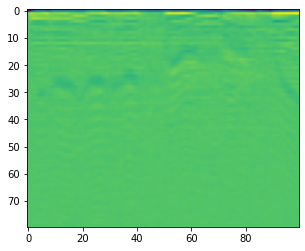

In [32]:
plt.imshow(x_spt[0][0][0].T.detach().cpu().numpy())

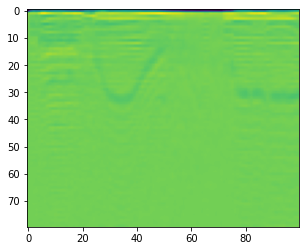

In [33]:
plt.imshow(nshot.dataset_train.load_data(0)['mel'].T.detach().cpu().numpy())

In [34]:
import librosa

y, sr = librosa.load(nshot.dataset_train.x[0], sr = None)

mspec = librosa.feature.melspectrogram(y, sr, fmin = 80, fmax = 7600, hop_length = 256, n_fft = 1024, n_mels = 80)

mfcc = librosa.feature.mfcc(S = np.log(mspec + 1e-6), n_mfcc= 20, htk=False)

In [39]:
sr

22050

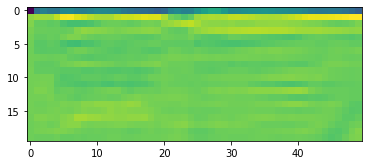

In [40]:
plt.imshow(mfcc[:,:50])

In [41]:
# mfcc = np.log(mfcc + 1e-6)

In [42]:
mfcc.max(), mfcc.min(), mfcc.mean()

(44.20903, -116.772064, -2.9181387)

In [43]:
1e-6

1e-06

In [44]:
accs

NameError: name 'accs' is not defined

In [46]:
accs = []
for _ in range(10//args.task_num):
    # test
    x_spt, y_spt, x_qry, y_qry = nshot.next('test')
    x_spt, y_spt, x_qry, y_qry = torch.from_numpy(x_spt).to(device), torch.from_numpy(y_spt).to(device).type(torch.LongTensor), \
                                 torch.from_numpy(x_qry).to(device), torch.from_numpy(y_qry).to(device).type(torch.LongTensor)

    # split to single task each time
    for x_spt_one, y_spt_one, x_qry_one, y_qry_one in zip(x_spt, y_spt, x_qry, y_qry):
        test_acc = maml.finetunning(x_spt_one, y_spt_one, x_qry_one, y_qry_one)
        accs.append( test_acc )
ii
    print("DONE!")
# [b, update_step+1]
accs = np.array(accs).mean(axis=0).astype(np.float16)
print('Test acc:', accs)


KeyboardInterrupt: 

In [47]:
x_spt_one.shape

torch.Size([3, 1, 100, 80])

In [48]:
from    copy import deepcopy
net = deepcopy(maml.net)

from    torch.nn import functional as F

# 1. run the i-th task and compute loss for k=0
logits = net(x_spt_one)
loss = F.cross_entropy(logits, y_spt_one)
grad = torch.autograd.grad(loss, net.parameters())
fast_weights = list(map(lambda p: p[1] - maml.update_lr * p[0], zip(grad, net.parameters())))

In [50]:
losses = []

losses.append(loss)
losses.append(loss)
losses.append(loss)

In [51]:
losses

[tensor(3.4814, grad_fn=<NllLossBackward>),
 tensor(3.4814, grad_fn=<NllLossBackward>),
 tensor(3.4814, grad_fn=<NllLossBackward>)]

In [53]:
loss*0.1 + loss*0.3

tensor(1.3925, grad_fn=<AddBackward0>)

In [55]:
weights = [0.1*i for i in range(2 + 1)]
weights

[0.0, 0.1, 0.2]

In [60]:
sum(weights)

0.30000000000000004

In [56]:
sum(losses)

tensor(10.4441, grad_fn=<AddBackward0>)

In [ ]:
logits_q = net(x_qry_one, fast_weights, bn_training=True)

In [ ]:
logits_q.shape, x_qry_one.shape

In [ ]:
pred_q = F.softmax(logits_q, dim=1).argmax(dim=1)
correct = torch.eq(pred_q, y_qry_one).sum().item()  # convert to numpy

In [ ]:
test_acc

In [ ]:
test_acc

In [ ]:
len(accs)

In [ ]:
10//args.task_num

In [ ]:
x_qry_one.shape

In [ ]:
x_spt_one.shape